<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Multivariate Multi-Step LSTM models



# What is a multivariate multi-step time series analysis?


- **Multivariate** = more than one observation/target per time step.
- **Multi-step** = predicting of multiple time steps into the future.


- We'll look at 2 cases here:
    - Multiple Input Multi-Step Output.
    - Multiple Parallel Input and Multi-Step Output.

- The most laborious part of the preparation of the data.
    


# Import modules

In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Helper functions

In [6]:
def plotLearningHistory(history):
    """Plot learning history.
    """
    
    epochs = len(history.history[ "loss"]) 
    x = range(0, epochs)

    rcParams['figure.figsize'] = 15, 5
    rcParams['font.size'] = 20

    fig, ax = plt.subplots()
    ax.plot(x, history.history[ "loss"], 'r-', lw = 3, label = 'Train') 

    ax.legend() 
    plt.xlabel('Epochs')
    plt.ylabel("MSE")
    plt.title('Training history')

    ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which = 'major', direction='in', length=10, width=2)
    ax.tick_params(which = 'minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    plt.yscale('log')
    ax.minorticks_on()
    plt.show()

# Multiple Input Multi-Step Output

## Create dataset


- There are those multivariate time series forecasting problems where the output series is separate but dependent upon the input time series, and multiple time steps are required for the output series.



In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

In [9]:
print(out_seq)

[ 25  45  65  85 105 125 145 165 185]


In [10]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [12]:
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [13]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [18]:
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

(6, 3, 2) (6, 2)
[[10 15]
 [20 25]
 [30 35]] [65 85]
[[20 25]
 [30 35]
 [40 45]] [ 85 105]
[[30 35]
 [40 45]
 [50 55]] [105 125]
[[40 45]
 [50 55]
 [60 65]] [125 145]
[[50 55]
 [60 65]
 [70 75]] [145 165]
[[60 65]
 [70 75]
 [80 85]] [165 185]


In [16]:
X[0]

array([[10, 15],
       [20, 25],
       [30, 35]])

In [17]:
y[0]

array([65, 85])

## Stacked LSTM model

In [20]:
# The dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# Define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [25]:
# Fit model
history = model.fit(X, y, epochs = 350, verbose=0)

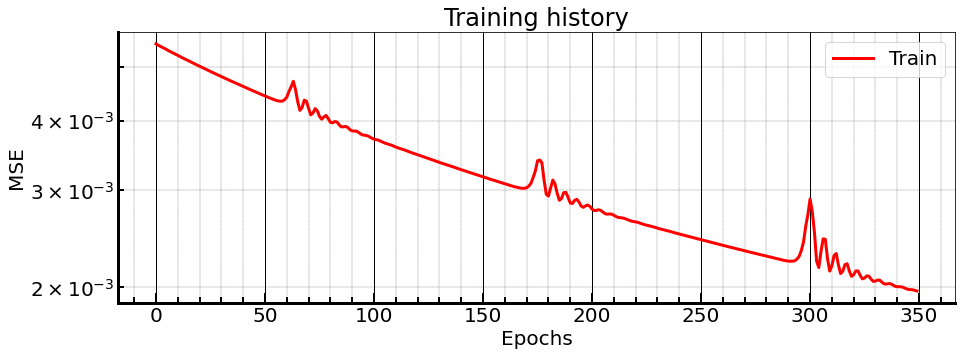

In [26]:
plotLearningHistory(history)

In [28]:
# Demonstrate prediction
x_input = np.array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[185.48186 205.84187]]


# Multiple Parallel Input and Multi-Step Output


- A problem with parallel time series may require the prediction of multiple time steps of each time series.



## Create dataset

In [43]:
# split a multivariate sequence into samples
def split_sequences_v2(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [44]:
# Define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

In [45]:
# Convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [46]:
# Horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [54]:
# Choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences_v2(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# See the data
for i in range(len(X)):
    print(X[i])
    print(y[i])

(5, 3, 3) (5, 2, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]]
[[ 40  45  85]
 [ 50  55 105]]
[[20 25 45]
 [30 35 65]
 [40 45 85]]
[[ 50  55 105]
 [ 60  65 125]]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]]
[[ 60  65 125]
 [ 70  75 145]]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]]
[[ 70  75 145]
 [ 80  85 165]]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]]
[[ 80  85 165]
 [ 90  95 185]]


## Encoder-Decoder LSTM model


- We can use either the Vector Output or Encoder-Decoder LSTM to model this problem. 
- In this case, we will use the Encoder-Decoder model.



In [48]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model1 = Sequential()
model1.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model1.add(RepeatVector(n_steps_out))
model1.add(LSTM(200, activation='relu', return_sequences=True))
model1.add(TimeDistributed(Dense(n_features)))
model1.compile(optimizer='adam', loss='mse')

In [58]:
# Fit model
history1 = model1.fit(X, y, epochs = 300, verbose=0)

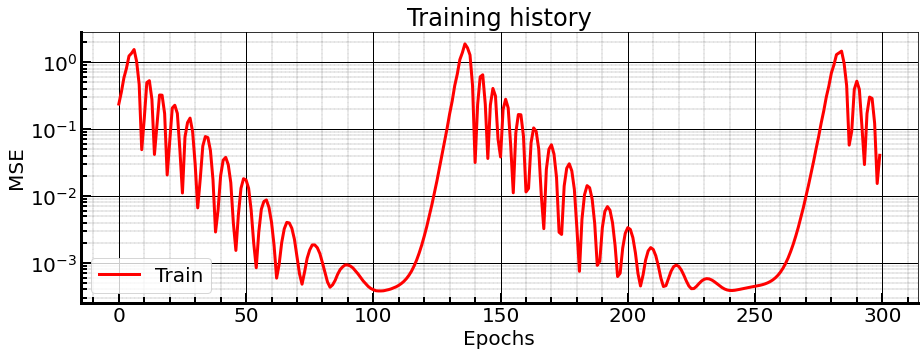

In [59]:
plotLearningHistory(history1)

In [60]:
# Make prediction
x_input = np.array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model1.predict(x_input, verbose=0)
print(yhat)

[[[ 90.744705  96.09444  186.62897 ]
  [101.673615 107.15234  208.54407 ]]]


# References
<hr style="border:2px solid black"> </hr>


- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

